## Principal Component Analysis of "differential" peaks

In [1]:
# import everything
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable

import util

In [10]:
# load all our (meta)data
samples = pd.read_csv(util.samples_url, sep="\t", comment="#", index_col=0)
samples = pd.concat([samples, samples[samples["replicate"].notna()].drop_duplicates("replicate").set_index("replicate")])

# make sure to work with the correct assemblies
if 'snakemake' in globals():
    assemblies = snakemake.params
else:
    assemblies = [x[0].split("/")[1] for x in os.walk("gimme_smooth") if len(x[0].split("/")) > 1]

print(assemblies)
    
# get the "differential" peaks 
dfs_smooth = dict()
for assembly in assemblies:
    dfs_smooth[assembly] = pd.read_csv(f"gimme_smooth/{assembly}_differentialpeaks_20points.tsv", sep="\t", comment="#", index_col=0)
    
# get the true values
dfs_true_values = dict()
for assembly in dfs_smooth.keys():
    dfs_true_values[assembly] = pd.read_csv(f"../data/count_tables/{assembly}_log2_quantilenorm.tsv", sep="\t", comment="#", index_col=0)

        
studies = dict()
# remove non-hpf columns
for assembly in dfs_smooth.keys():    
    columns = list(set(dfs_true_values[assembly].columns) & set(samples.index))
    remove_cols = [col for col in dfs_true_values[assembly].columns if col not in columns]
    dfs_true_values[assembly] = dfs_true_values[assembly].drop(columns=remove_cols)
    studies[assembly] = [samples.loc[col, "study"] for col in dfs_true_values[assembly].columns]
    dfs_true_values[assembly].columns = [samples.loc[col, "hpf"] for col in dfs_true_values[assembly].columns]


['Astyanax_mexicanus-2.0', 'mm10', 'mm10', 'GRCg6a', 'danRer11', 'ASM223467v1', 'Bl71nemr', 'xenTro9', 'ASM318616v1']


In [11]:
for assembly, study in studies.items():
    print(assembly, len(set(study)))

Astyanax_mexicanus-2.0 1
mm10 1
GRCg6a 1
danRer11 3
ASM223467v1 3
Bl71nemr 1
xenTro9 1
ASM318616v1 1


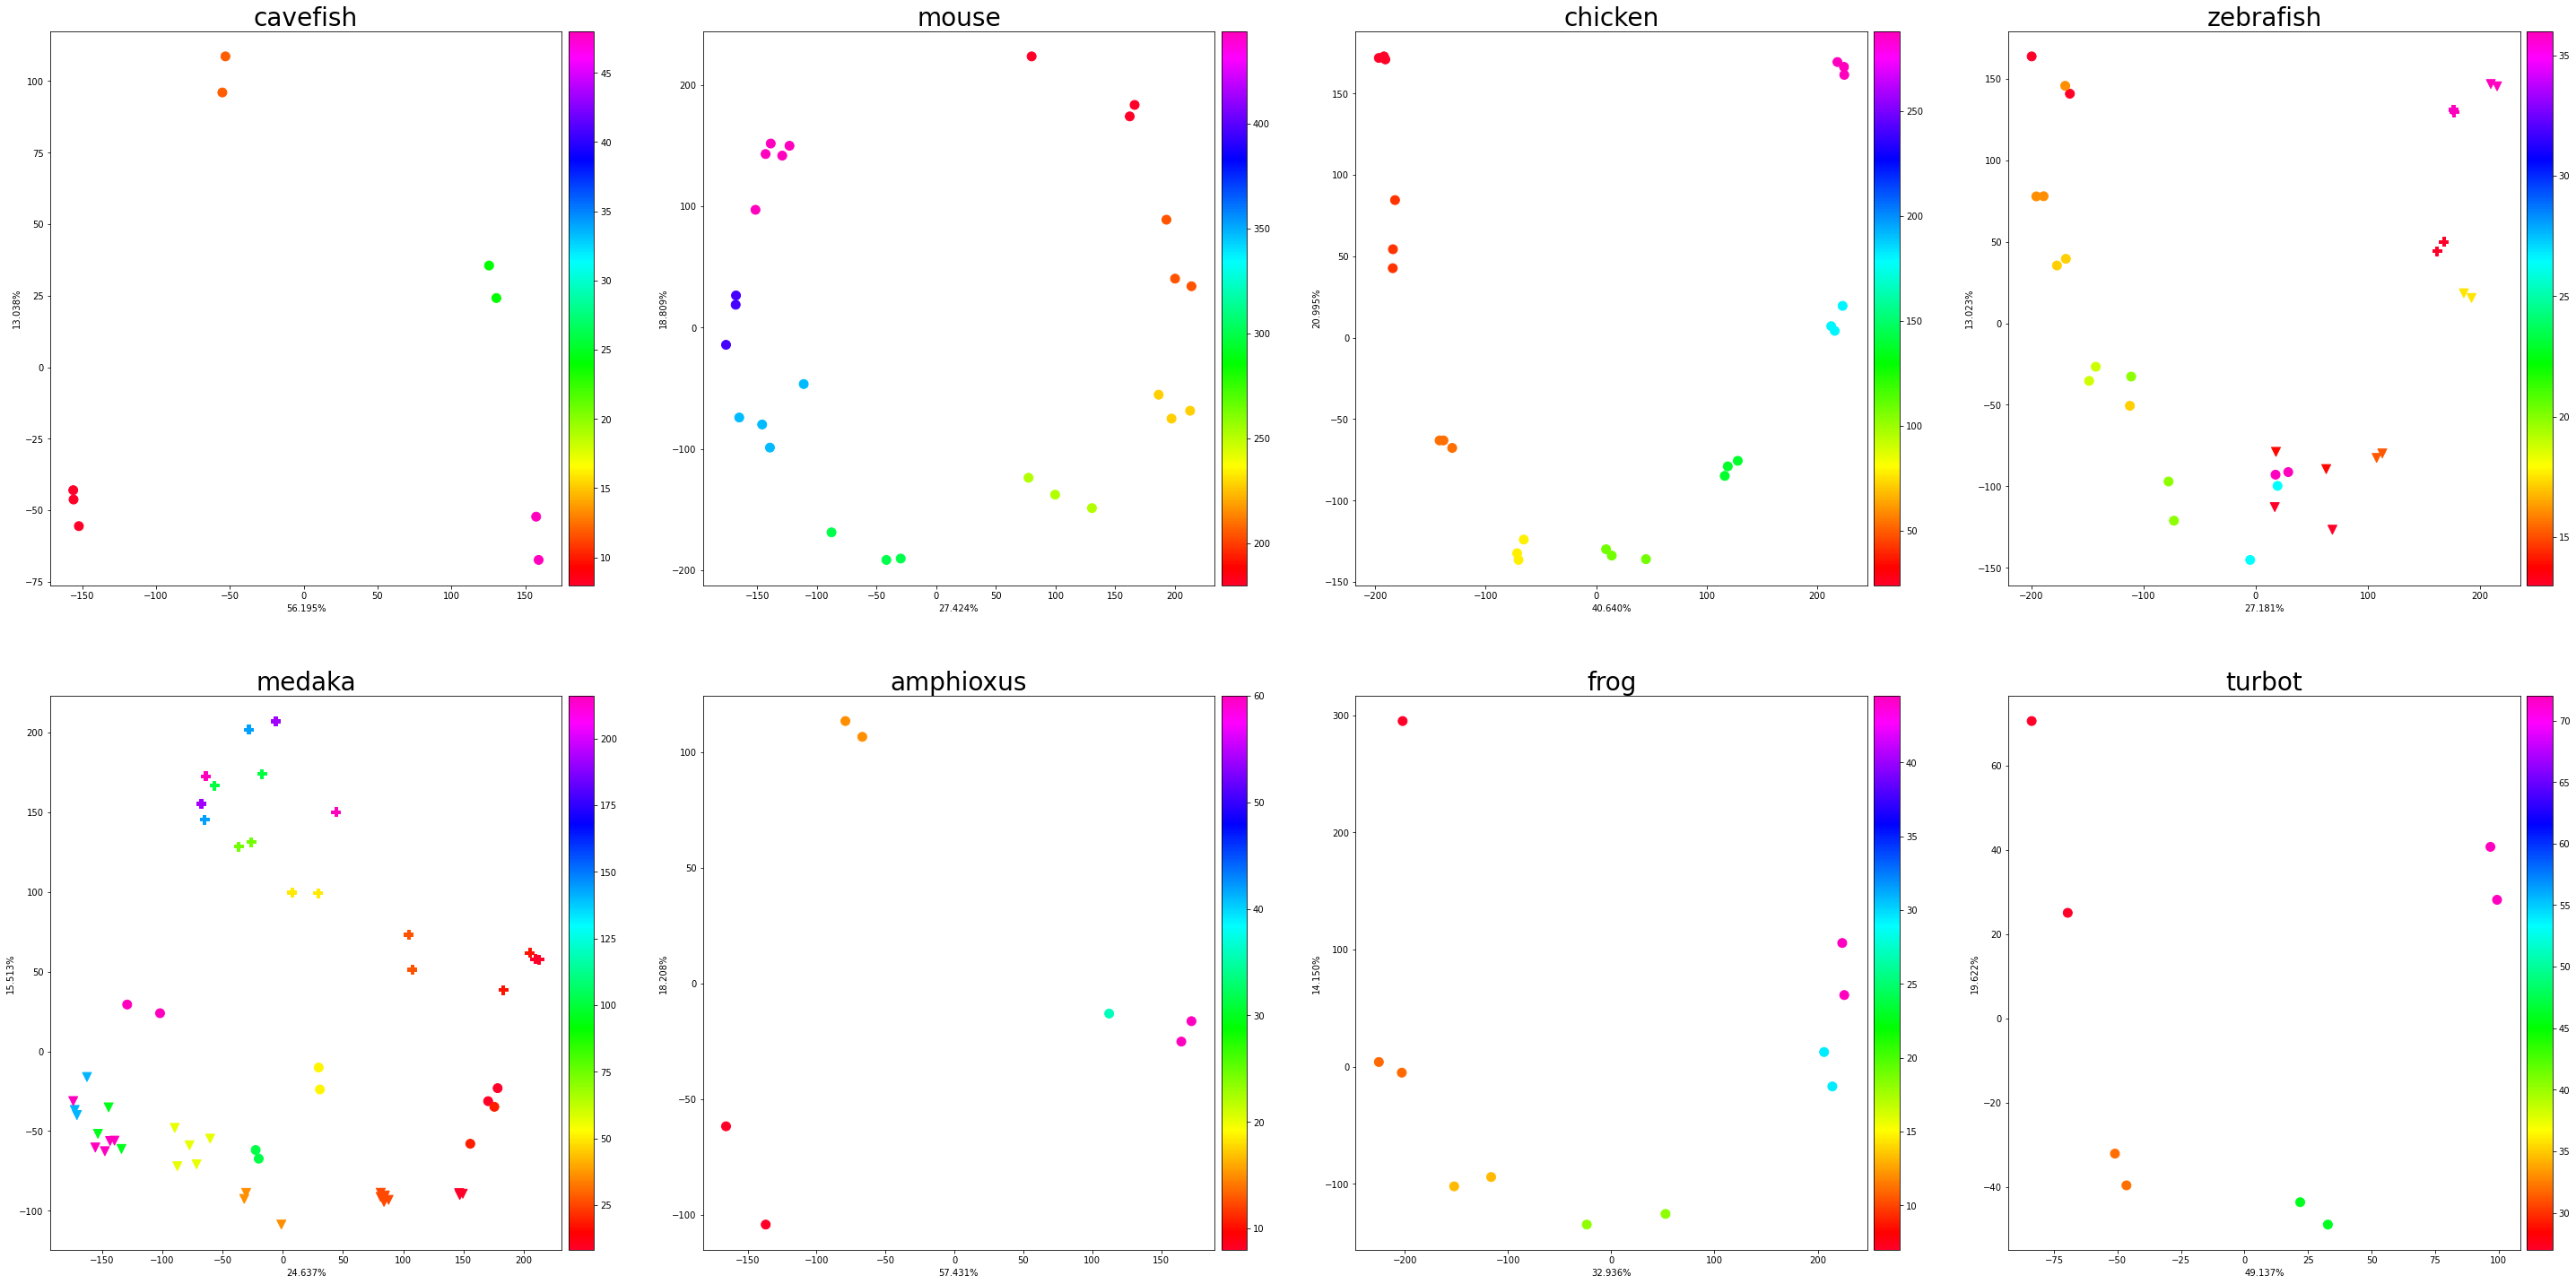

In [25]:
ncols = 4
nrows = len(dfs_true_values) // ncols

fig, axes = plt.subplots(figsize=(50, 25), nrows=nrows, ncols=ncols)

for i in range(ncols * nrows):
    ax = axes[i // ncols, i % ncols]
    if i < len(dfs_true_values):
        assembly, df = list(dfs_true_values.items())[i]
        pca = PCA(n_components=2)
        pca.fit(df.transpose())
        x = pca.transform(df.transpose())

        for study, marker in zip(set(studies[assembly]), ["o", "v", "P"]):
            idxs = [i for i, st in enumerate(studies[assembly]) if st == study]
            sc = ax.scatter(x[idxs,0], 
                            x[idxs,1], 
                            c=np.array([float(col) for col in df.columns[idxs]]),
                            cmap="gist_rainbow",
                            marker=marker,
                            s=100)

        ax.set_xlabel(f"{100*pca.explained_variance_ratio_[0]:.3f}%")
        ax.set_ylabel(f"{100*pca.explained_variance_ratio_[1]:.3f}%")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(sc, cax=cax)

        ax.set_title(util.ass2name(assembly), fontdict={"fontsize": 28})
    else:
        ax.axis('off')

plt.show()